### Initialization

##### Installation

In [1]:
%pip install --upgrade pip
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.6 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


##### Imports

In [2]:
# system imports
import os
import cv2
import uuid
import json
import joblib
from typing import Any

# utility imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# third-party imports
from rembg import remove

# ML imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor


##### Global vars

In [3]:
filename = 'strip3.png'
if not os.path.exists(f'assets/{filename}'):
    raise FileNotFoundError(f"File '{filename}' does not exist.")

dir_identifier = uuid.uuid4().hex # 'teste'
extension = filename.split('.')[-1]
filename = filename.split('.')[0]

os.makedirs(f'outputs/{dir_identifier}', exist_ok=True)


##### Generate dataset (from a LabelStudio annotation)

In [8]:
scale = cv2.cvtColor(cv2.imread("artifacts/scale-balanced.png"), cv2.COLOR_BGR2RGB)
img_height, img_width = scale.shape[:2]

with open("artifacts/annotations.json") as f:
    annotations = json.load(f)

points_by_label = {"Q1": [], "Q2": [], "Q3": [], "Q4": []}

for result in annotations[0]['annotations'][0]['result']:
    label = result['value']['keypointlabels'][0]
    x_pct = result['value']['x']
    y_pct = result['value']['y']

    x = int(x_pct / 100 * img_width)
    y = int(y_pct / 100 * img_height)

    r, g, b = scale[y, x]
    points_by_label[label].append((r, g, b))

num_points = 30
assert all(len(points_by_label[q]) == num_points for q in ["Q1", "Q2", "Q3", "Q4"])

ph_values = [i * 0.5 for i in range(num_points)]
data = []

for i, ph in enumerate(ph_values):
    row = [ph]
    for q in ["Q1", "Q2", "Q3", "Q4"]:
        r, g, b = points_by_label[q][i]
        row.extend([r, g, b])
    data.append(row)

columns = ["pH"]
for i in range(1, 5):
    columns += [f"R{i}", f"G{i}", f"B{i}"]

df = pd.DataFrame(data, columns=columns)

df.to_csv("artifacts/ph-scale-dataset.csv", index=False)
print("✅ Generated csv: ph-scale-dataset.csv")
df.head()


✅ Generated csv: ph-scale-dataset.csv


,pH,R1,G1,B1,R2,G2,B2,R3,G3,B3,R4,G4,B4
0,0.0,175,116,79,190,137,43,148,189,177,193,157,36
1,0.5,185,122,62,191,139,43,141,182,169,193,154,38
2,1.0,195,130,53,195,139,42,146,180,152,194,156,35
3,1.5,185,131,27,197,138,38,145,178,155,185,147,19
4,2.0,184,137,28,187,135,32,142,176,146,186,145,26


##### Train, save and load kNN model

In [9]:
X = df.drop(columns=["pH"])
y = df["pH"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')

knn.fit(X_scaled, y)

model_path = f'models/knn_model.pkl'
joblib.dump(knn, model_path)
print(f"✅ Saved model to {model_path}")

scaler_path = 'models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✅ Saved scaler to {scaler_path}")


✅ Saved model to models/knn_model.pkl
✅ Saved scaler to models/scaler.pkl


##### Plot function (to compare and save two images)

In [10]:
def plot_images(
    step: str,
    original: np.ndarray,
    processed: np.ndarray,
    title1: str = 'Original',
    title2: str = 'Processed'
) -> None:
    """
    Plots two images side by side for comparison.

    Args:
        step (str): Step identifier for the image.
        original (np.ndarray): The original image to be displayed.
        processed (np.ndarray): The processed image to be displayed.
        title1 (str, optional): Title for the original image. Defaults to 'Original'.
        title2 (str, optional): Title for the processed image. Defaults to 'Processed'.
    """

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[0].set_title(title1)
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    axs[1].set_title(title2)
    axs[1].axis('off')

    plt.tight_layout()
    
    cv2.imwrite(f'outputs/{dir_identifier}/{filename}-{step}.{extension}', processed)
    plt.savefig(f'outputs/{dir_identifier}/plot-{filename}-{step}.{extension}')
    plt.show()

### Remove background of pH strip

##### Remove background

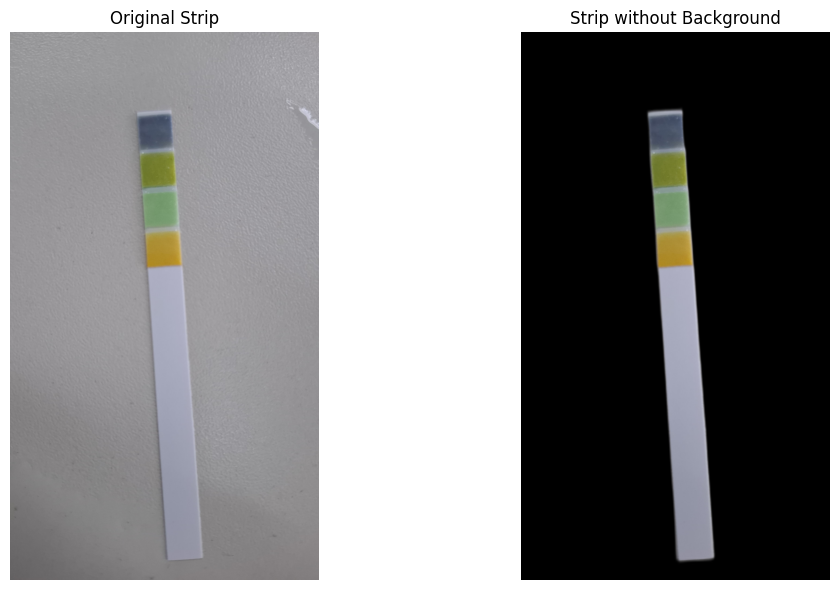

In [11]:
def remove_background(
  strip: np.ndarray,
) -> np.ndarray:
    """
    Removes the background from the strip image using rembg.

    Args:
        strip (np.ndarray): The input image with a background.

    Returns:
        np.ndarray: The image with the background removed.
    """
    strip_without_bg = remove(strip)
    
    plot_images(
        step='1-remove-bg',
        original=strip,
        processed=strip_without_bg,
        title1='Original Strip',
        title2='Strip without Background'
    )
    return strip_without_bg

strip = cv2.imread(f'assets/{filename}.{extension}')
strip_without_bg = remove_background(strip)

### Adjust strip

##### Rotate strip

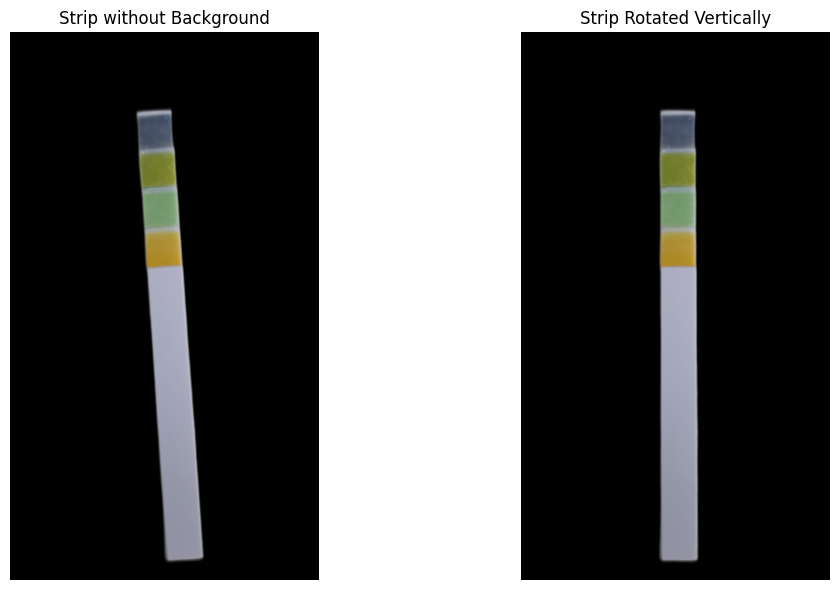

In [12]:
def rotate_vertically(strip: np.ndarray) -> np.ndarray:
    """
    Aligns the strip vertically by detecting its orientation.

    Args:
        strip (np.ndarray): Input image of the strip.

    Returns:
        np.ndarray: The rotated image of the strip aligned vertically.
    """
    gray = cv2.cvtColor(strip, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("Nenhum contorno encontrado.")

    largest_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    angle = rect[-1]
    width, height = rect[1]

    if width > height:
        corrected_angle = angle - 90
    else:
        corrected_angle = angle

    if corrected_angle < -45:
        corrected_angle += 90

    (h, w) = strip.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, corrected_angle, 1.0)

    rotated = cv2.warpAffine(
        strip,
        M,
        (w, h),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0)
    )

    gray_rotated = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    _, binary_rotated = cv2.threshold(gray_rotated, 10, 255, cv2.THRESH_BINARY)
    top_half = binary_rotated[:h // 2, :]
    bottom_half = binary_rotated[h // 2:, :]

    top_mass = cv2.countNonZero(top_half)
    bottom_mass = cv2.countNonZero(bottom_half)

    if top_mass > bottom_mass:
        rotated = cv2.flip(rotated, 0)

    plot_images(
        step='2-rotate-vertically',
        original=strip,
        processed=rotated,
        title1='Strip without Background',
        title2='Strip Rotated Vertically'
    )

    return rotated



rotated_strip = rotate_vertically(strip_without_bg)


##### Crop strip

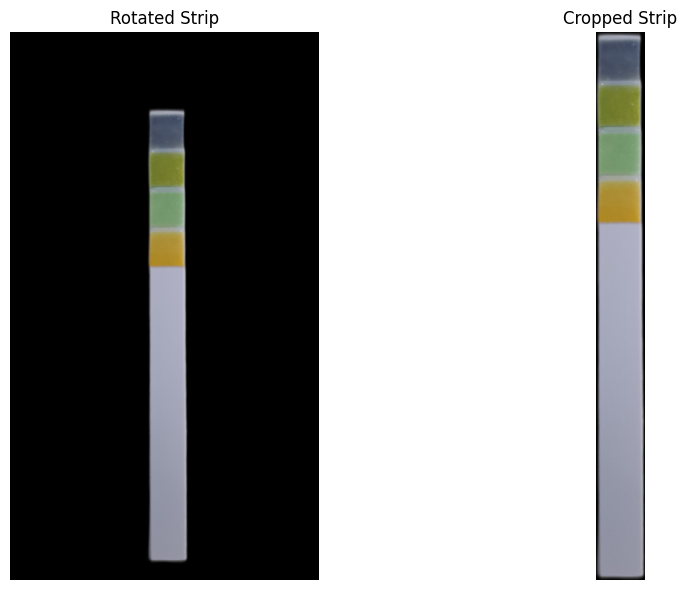

In [13]:
def crop(    
    strip: np.ndarray,
) -> np.ndarray:
    """
    Crops the strip strip to remove any excess background.

    Args:
        strip (np.ndarray): The strip image of the strip.

    Returns:
        np.ndarray: The cropped image of the strip.
    """
    gray_strip = cv2.cvtColor(strip, cv2.COLOR_BGR2GRAY)
    _, binary_strip = cv2.threshold(gray_strip, 10, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_strip, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    cropped = strip[y:y+h, x:x+w]

    plot_images(
        step='3-crop',
        original=strip,
        processed=cropped,
        title1='Rotated Strip',
        title2='Cropped Strip'
    )

    return cropped
  
cropped_strip = crop(rotated_strip)

##### Colour balance

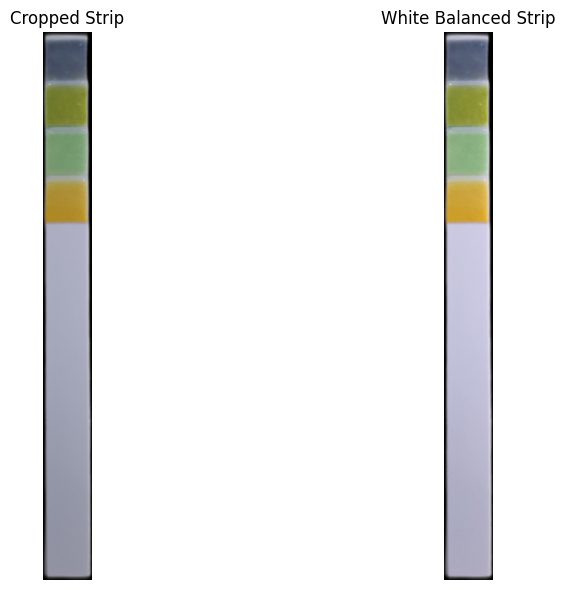

In [14]:
def white_balance_gray_world(
    strip: np.ndarray,
) -> np.ndarray:
    """
    Applies white balance to the strip image.

    Args:
        strip (np.ndarray): The cropped image of the strip.

    Returns:
        np.ndarray: The white balanced image of the strip.
    """
    mean_rgb = strip.mean(axis=(0, 1))
    mean_gray = mean_rgb.mean()
    
    gain = mean_gray / mean_rgb
    balanced = strip.astype(np.float32) * gain
    
    balanced = np.clip(balanced, 0, 255).astype(np.uint8)
    
    plot_images(
        step='4-white-balance',
        original=strip,
        processed=balanced,
        title1='Cropped Strip',
        title2='White Balanced Strip'
    )
    
    return balanced

white_balanced_strip = white_balance_gray_world(cropped_strip)



### Extract RGBA

##### Extract with "rule of 3"

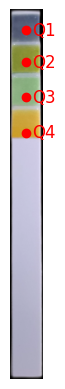

,R,G,B
Q1,86,97,119
Q2,143,149,55
Q3,139,178,131
Q4,204,159,45


In [15]:
y_measures_cm = {
    'Q1': 0.7,
    'Q2': 1.8,
    'Q3': 3.0,
    'Q4': 4.2,
    'total': 12.6
}


def extract_rgbs(
    strip: np.ndarray,
    y_measures_cm: dict[str, float],
) -> pd.DataFrame:
    """
    Extracts RGB values from the strip image at specified y-coordinates to a data frame, with Q1, Q2, Q3 and Q4 indexed by y-coordinates in cm.

    Args:
        strip (np.ndarray): The white balanced image of the strip.
        y_measures_cm (dict[str, float]): Dictionary with y-coordinates in cm.

    Returns:
        pd.DataFrame: DataFrame containing RGB values and their corresponding y-coordinates.
    """
    strip = cv2.cvtColor(strip, cv2.COLOR_BGR2RGB)
    
    height, width, _ = strip.shape
    center_x = width // 2

    df_data = {}
    for key in ['Q1', 'Q2', 'Q3', 'Q4']:
        proportion = y_measures_cm[key] / y_measures_cm['total']
        y_pos = int(proportion * height)
        y_pos = min(max(y_pos, 0), height - 1)
        rgb = strip[y_pos, center_x]
        df_data[key] = rgb[:3]

    df = pd.DataFrame(df_data, index=['R', 'G', 'B']).T

    plt.imshow(strip)
    for key in ['Q1', 'Q2', 'Q3', 'Q4']:
        proportion = y_measures_cm[key] / y_measures_cm['total']
        y_pos = int(proportion * height)
        plt.plot(center_x, y_pos, 'ro')
        plt.text(center_x + 50, y_pos, key, color='red', fontsize=12, verticalalignment='center')

    plt.axis('off')
    plt.savefig(f'outputs/{dir_identifier}/{filename}-5-extract-rgbs.{extension}', bbox_inches='tight', pad_inches=0)
    plt.show()

    df.to_csv(f'outputs/{dir_identifier}/{filename}-5-extract-rgbs.csv', index_label='Color')
    
    return df

rgb_df = extract_rgbs(white_balanced_strip, y_measures_cm)
rgb_df




### Predict pH

##### Predict with kNN

In [16]:
def predict_ph(rgb_df: pd.DataFrame, model_path='models/knn_model.pkl', scaler_path='models/scaler.pkl'):
    """
    Receives a DataFrame rgb_df with index ['Q1', 'Q2', 'Q3', 'Q4'] and columns ['R', 'G', 'B'].
    Loads the kNN model and scaler from the specified paths.
    Predicts the pH value based on the RGB values and returns it.
    
    Args:
        rgb_df (pd.DataFrame): DataFrame with RGB values indexed by Q1, Q2, Q3, and Q4.
        model_path (str): Path to the saved kNN model.
        scaler_path (str): Path to the saved scaler.
    Returns:
        float: Predicted pH value.
    """
    knn = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    features_flat = []
    for q in ['Q1', 'Q2', 'Q3', 'Q4']:
        rgb = rgb_df.loc[q].values
        features_flat.extend(rgb.tolist())

    features_array = np.array(features_flat).reshape(1, -1)

    features_normalizado = scaler.transform(features_array)

    ph_predict = knn.predict(features_normalizado)

    with open(f'outputs/{dir_identifier}/{filename}-6-predicted-ph.txt', 'w') as f:
      f.write(f"Predicted pH: {ph_predict[0]}\n")
      
    return ph_predict[0]
  
ph = predict_ph(rgb_df)
print(f"Predicted pH: {ph}")



Predicted pH: 6.30594034619069


/home/vic/.pyenv/versions/phia/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
